<a href="https://colab.research.google.com/github/viha-20/PoC-Proof-of-Concept-_Leveraging-CPD-for-Enhanced-CCF-/blob/main/Final_POC_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  fl

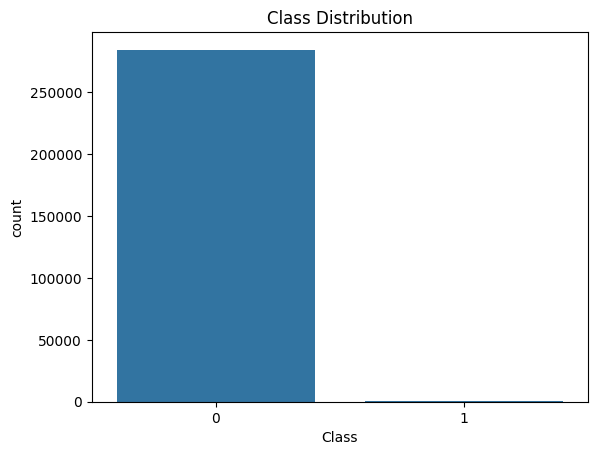

In [ ]:
# Load dataset
data = pd.read_csv("creditcard.csv")

# Display basic information
print("Dataset Information:")
data.info()

# Check for missing values
print("\nMissing Values in each Column:")
print(data.isnull().sum())

# Show the distribution of the target variable
sns.countplot(x='Class', data=data)
plt.title("Class Distribution")
plt.show()

In [ ]:
# Check for duplicates
print("Number of duplicate rows:", data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)

# Feature engineering: Create a few basic statistical features
data['amount_diff'] = data['Amount'].diff().fillna(0)  # Difference between transactions
data['rolling_mean_amount'] = data['Amount'].rolling(window=5, min_periods=1).mean()
data['rolling_std_amount'] = data['Amount'].rolling(window=5, min_periods=1).std().fillna(0)


Number of duplicate rows: 1081


In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name} Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


# **Step 5: Implement and Evaluate Models**








Isolation Forest Model Evaluation Metrics:
Accuracy: 50.87%
Precision: 0.94
Recall: 0.02
F1 Score: 0.04


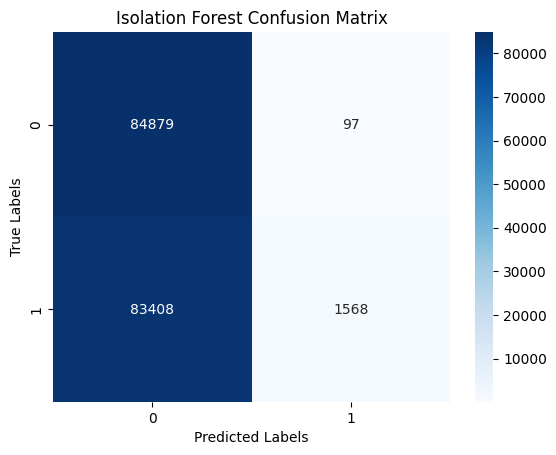

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on test data
iso_forest_pred = iso_forest.predict(X_test)
iso_forest_pred = [1 if x == -1 else 0 for x in iso_forest_pred]

# Evaluate Isolation Forest model
evaluate_model(y_test, iso_forest_pred, "Isolation Forest")



One-Class SVM Model Evaluation Metrics:
Accuracy: 90.22%
Precision: 0.94
Recall: 0.85
F1 Score: 0.90


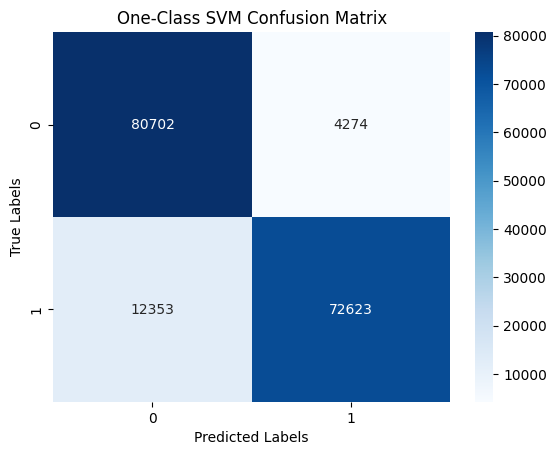

In [ ]:
from sklearn.svm import OneClassSVM

# Fit One-Class SVM on non-fraud data in training set
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)
oc_svm.fit(X_train[y_train == 0])

# Predict anomalies on test data
oc_svm_pred = oc_svm.predict(X_test)
oc_svm_pred = [1 if x == -1 else 0 for x in oc_svm_pred]

# Evaluate One-Class SVM model
evaluate_model(y_test, oc_svm_pred, "One-Class SVM")



Local Outlier Factor Model Evaluation Metrics:
Accuracy: 49.99%
Precision: 0.49
Recall: 0.01
F1 Score: 0.02


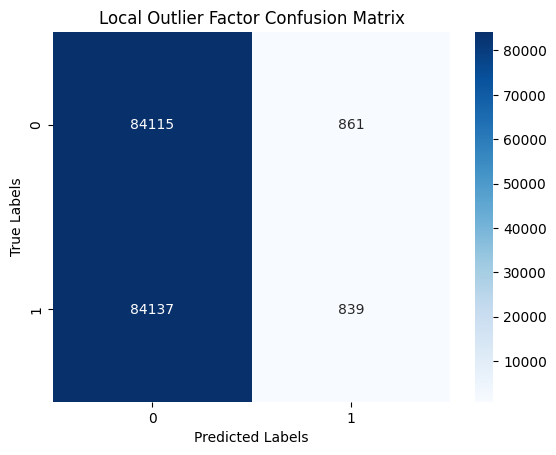

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Fit Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_pred = lof.fit_predict(X_test)
lof_pred = [1 if x == -1 else 0 for x in lof_pred]

# Evaluate Local Outlier Factor model
evaluate_model(y_test, lof_pred, "Local Outlier Factor")



Mahalanobis Distance Model Evaluation Metrics:
Accuracy: 50.28%
Precision: 0.55
Recall: 0.03
F1 Score: 0.06


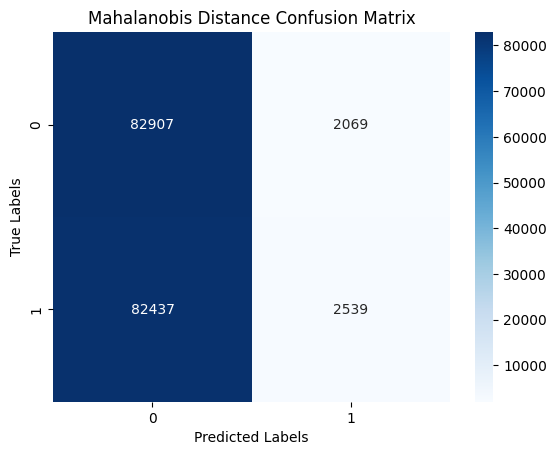

In [ ]:
from scipy.spatial.distance import mahalanobis

# Calculate Mahalanobis distance for each sample in the test set
mean = np.mean(X_train, axis=0)
cov_matrix = np.cov(X_train, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(row, mean, inv_cov_matrix):
    return mahalanobis(row, mean, inv_cov_matrix)

mahal_distances = np.apply_along_axis(lambda x: mahalanobis_distance(x, mean, inv_cov_matrix), 1, X_test)
threshold = np.mean(mahal_distances) + 2 * np.std(mahal_distances)

# Predict anomalies based on Mahalanobis distance threshold
mahalanobis_pred = [1 if dist > threshold else 0 for dist in mahal_distances]

# Evaluate Mahalanobis model
evaluate_model(y_test, mahalanobis_pred, "Mahalanobis Distance")


Epoch 1/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.8015 - val_loss: 0.6929
Epoch 2/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.6995 - val_loss: 0.6816
Epoch 3/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.6927 - val_loss: 0.6771
Epoch 4/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.6923 - val_loss: 0.6733
Epoch 5/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.6598 - val_loss: 0.6692
Epoch 6/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.6695 - val_loss: 0.6715
Epoch 7/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.6543 - val_loss: 0.6665
Epoch 8/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.6600 - val_loss: 0.6628
Epoch 9/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.6591 - val_loss: 0.6622
Epoch 10/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.6398 - val_loss: 0.6603
Epoch 11/20
5577/5577 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6584 - val_loss: 0.6595
Epoch 12/20
5577/55

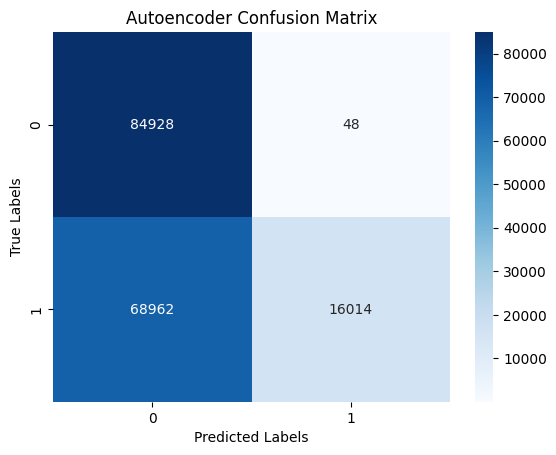

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and train the Autoencoder on non-fraud transactions
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0], epochs=20, batch_size=32, validation_split=0.1)

# Calculate reconstruction error on test data
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)

# Predict anomalies based on reconstruction error
autoencoder_pred = [1 if error > threshold else 0 for error in mse]

# Evaluate Autoencoder model
evaluate_model(y_test, autoencoder_pred, "Autoencoder")
